# Neural differential solver
Implementation and analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from typing import List, Callable

## Implementation
Neural differential solver functionality:

In [2]:
class DNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


# TODO Explore including convolutional layers to the network
class ConvDNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


def calcGradients(function, x, order):
    if order == 0:
        return function(x)
    y = function(x)
    grads = grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    for _ in range(1, order):
        grads = grad(outputs=grads, inputs=x, grad_outputs=torch.ones_like(grads), create_graph=True)[0]
    return grads


class LossFunction(nn.Module):
    def __init__(self, differential_expressions: List[Callable], bc_grad_orders: List[int], 
                 bc_functions: list[Callable], bc_boundaries: List[float], ):
        super(LossFunction, self).__init__()
        self.differential_expressions = differential_expressions
        self.problem_order = len(bc_boundaries)
        self.bc_grad_orders = bc_grad_orders
        self.bc_functions = bc_functions
        bc_boundaries_temp = [float(b) for b in bc_boundaries]
        self.bc_boundaries = torch.tensor(bc_boundaries_temp, requires_grad=True)
        assert self.problem_order == len(self.bc_grad_orders) and self.problem_order == len(self.bc_functions)

    def _calcBoundaryCondition(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool):
        bc_terms = []
        for bc_i in range(self.problem_order):
            bc_boundary = self.bc_boundaries[bc_i]
            # NB bc_boundary is tensor. Does `x_data == bc_boundary` in this case?
            bc_boundary_inds = (x_data == bc_boundary).nonzero()
            if bc_boundary_inds.numel() > 0:
                x_bc = x_data[bc_boundary_inds[0,0]]
                term1 = calcGradients(model, x_bc, self.bc_grad_orders[bc_i])  # grad_x^p_i model(x_{b_i})
                term2 = self.bc_functions[bc_i](x_bc)  # K_i(x_{p_i})
                if not isinstance(term2, torch.Tensor): 
                    term2 = torch.tensor([term2], requires_grad=True)  # Make sure term2 is tensor which grad is tracked
                # QUESTION If the function `bc_functions[bc_i]` returns a constant, does it matter if the (newly created) 
                # tensor tracks the gradient or not?
                bc_term_i = (term1 - term2)**2
                bc_terms.append(bc_term_i)
        if len(bc_terms) == 0:
            return torch.tensor(0.0, requires_grad=True)
        else:
            return torch.sum(torch.stack(bc_terms))

    def __call__(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool = False):
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        bc_term = self._calcBoundaryCondition(model, x_data, include_all_bc)
        return F_term + bc_term


# TODO ability to define grid using linspace and total number of points rather than discretization width
def genDataLoader(domain, discretization, batch_size=None, batch_shuffle=False):
    assert isinstance(domain, list) and all(isinstance(d, list) and len(d)==2 for d in domain), \
        "`domain` should be a list of lists all with two floats for lower and higher boundry of the dimension."
    ranges = [np.arange(d[0], d[1], discretization) for d in domain]
    grid = np.meshgrid(*ranges)
    x = np.stack([g.flatten() for g in grid], axis=-1)
    x_tensor = torch.from_numpy(x).float().requires_grad_(True)
    if batch_size is None:
        batch_size = len(x)
    dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)
    return dataloader


def training(model, loss_fn, dataloader, num_epochs, learning_rate, save_model_freq=None, save_model_path=None):
    if (save_model_path is not None) and (save_model_freq is None):
        raise TypeError("`save_model_path` is not defined while `save_model_freq` is given.")
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    model.train()  # Make sure to be in train mode
    for epoch_i in range(num_epochs):
        running_loss = 0.0
        for batch_i, batch_x in enumerate(dataloader):
            # Input data in appropriate shape
            batch_x = batch_x.unsqueeze(-1)
            # NB no need to specifically calculate forward push
            # Backpropagation
            optimizer.zero_grad()
            loss = loss_fn(model, batch_x)
            loss.backward()
            optimizer.step()
            # Keep track of loss
            running_loss += loss.item()
        
        # Potentially save the model at a given intervals
        if save_model_freq is not None:
            if (epoch_i + 1) % save_model_freq == 0:
                torch.save(model.state_dict(), "{}/epoch_{}.pth".format(save_model_path, epoch_i+1))

        loss_history.append(running_loss)
        # Print progress
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history


def traininigDomainExtension(model, loss_fn, domains, discretization, num_epochs_per_domain, learning_rate, 
                             save_model_freq=None, save_model_path=None, eval_function=None, eval_freq=1):
    if (save_model_path is not None) and (save_model_freq is None):
        raise TypeError("`save_model_path` is not defined while `save_model_freq` is given.")
    
    num_domains = len(domains)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    eval_history = {}  # {epoch: eval function result}
    for domain_i, domain in enumerate(domains):
        dataloader = genDataLoader(domain, discretization)

        model.train()  # Make sure to be in train mode
        for epoch_i in range(num_epochs_per_domain):
            running_loss = 0.0
            for batch_i, batch_x in enumerate(dataloader):
                # Input data in appropriate shape
                batch_x = batch_x.unsqueeze(-1)
                # NB no need to specifically calculate forward push
                # Backpropagation
                optimizer.zero_grad()
                loss = loss_fn(model, batch_x)
                loss.backward()
                optimizer.step()
                # Keep track of loss
                running_loss += loss.item()
            
            # Potentially save the model at a given intervals
            if save_model_freq is not None:
                if (epoch_i + 1) % save_model_freq == 0:
                    torch.save(model.state_dict(), "{}/epoch_{}.pth".format(save_model_path, epoch_i+1))

            loss_history.append(running_loss)
            # Print progress
            print("Domain {}/{}, Epoch {}/{} Loss: {:.4f}". format(domain_i+1, num_domains, epoch_i+1, 
                                                                   num_epochs_per_domain, running_loss))
            
            # Optionally calculate evaluation based on a separate function
            if eval_function is not None:
                if epoch_i % eval_freq == 0:
                    model.eval()
                    # TODO Ability to evaluate current model with a given function (e.g. the correct/analytic solution)
                    # NB remember to then also return the evaluation data alongside with `loss_history`.
                    model.train()
                    pass
            

    return loss_history
        

## Example 1
Solve $f'(x) - x - 1 = 0$ with boundary condition $f(0) = 0$ on $x \in [0,\infty]$. Analytic solution is $f(x) = x^2 / 2 + x + c$ where now $c = 0$.

Epoch 1/500 Loss: 4.4219
Epoch 2/500 Loss: 3.0187
Epoch 3/500 Loss: 1.7899
Epoch 4/500 Loss: 0.7204
Epoch 5/500 Loss: 0.6109
Epoch 6/500 Loss: 0.5935
Epoch 7/500 Loss: 2.2503
Epoch 8/500 Loss: 1.4803
Epoch 9/500 Loss: 1.0793
Epoch 10/500 Loss: 0.9814
Epoch 11/500 Loss: 0.5434
Epoch 12/500 Loss: 0.3254
Epoch 13/500 Loss: 0.5315
Epoch 14/500 Loss: 0.6166
Epoch 15/500 Loss: 0.5274
Epoch 16/500 Loss: 0.3736
Epoch 17/500 Loss: 0.2762
Epoch 18/500 Loss: 0.2412
Epoch 19/500 Loss: 0.2216
Epoch 20/500 Loss: 0.1767
Epoch 21/500 Loss: 0.1787
Epoch 22/500 Loss: 0.1892
Epoch 23/500 Loss: 0.1722
Epoch 24/500 Loss: 0.1308
Epoch 25/500 Loss: 0.0992
Epoch 26/500 Loss: 0.0949
Epoch 27/500 Loss: 0.1008
Epoch 28/500 Loss: 0.0964
Epoch 29/500 Loss: 0.0824
Epoch 30/500 Loss: 0.0660
Epoch 31/500 Loss: 0.0585
Epoch 32/500 Loss: 0.0546
Epoch 33/500 Loss: 0.0480
Epoch 34/500 Loss: 0.0434
Epoch 35/500 Loss: 0.0391
Epoch 36/500 Loss: 0.0324
Epoch 37/500 Loss: 0.0277
Epoch 38/500 Loss: 0.0242
Epoch 39/500 Loss: 0.

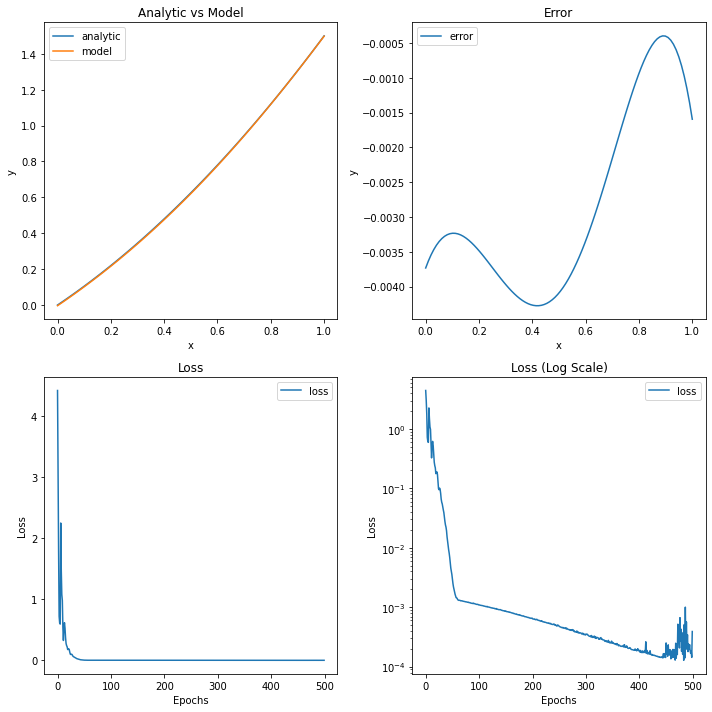

In [6]:
# --- Problem definitions ---
def equation(f, x):
    f_prime = calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function_1(x):
    return 0.0

bc_functions = [bc_function_1]
bc_ps = [0]
bc_xs = [0.0]

x_min = 0.0
x_max = 1.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 50
batch_shuffle = True

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [100, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 500
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    return x**2 * 0.5 + x

model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 2
Solve f''(x) - f'(x) + f(x) - 1 = 0 which has analytic solution $f(x) = c_2 e^{x/2} \sin(\sqrt{3} x / 2) + c_1 e^{x/2} \cos(\sqrt{3} x / 2) + 1$. For domain $x \in [0, 10]$ with boundary conditions $f(0) = 0$ and $f(10) = 0$ you have $c_1 = -1$, $c_2 = \frac{\csc \left(5 \sqrt{3}\right)-e^5 \cot \left(5 \sqrt{3}\right)}{e^5}$.

Epoch 1/1000 Loss: 9.6250
Epoch 2/1000 Loss: 3.9095
Epoch 3/1000 Loss: 2.1432
Epoch 4/1000 Loss: 2.0680
Epoch 5/1000 Loss: 1.9899
Epoch 6/1000 Loss: 1.8987
Epoch 7/1000 Loss: 1.9218
Epoch 8/1000 Loss: 1.8762
Epoch 9/1000 Loss: 1.8961
Epoch 10/1000 Loss: 1.8778
Epoch 11/1000 Loss: 1.8826
Epoch 12/1000 Loss: 1.8742
Epoch 13/1000 Loss: 1.8717
Epoch 14/1000 Loss: 1.8659
Epoch 15/1000 Loss: 1.8614
Epoch 16/1000 Loss: 1.8567
Epoch 17/1000 Loss: 1.8525
Epoch 18/1000 Loss: 1.8490
Epoch 19/1000 Loss: 1.8457
Epoch 20/1000 Loss: 1.8425
Epoch 21/1000 Loss: 1.8386
Epoch 22/1000 Loss: 1.8339
Epoch 23/1000 Loss: 1.8272
Epoch 24/1000 Loss: 1.8186
Epoch 25/1000 Loss: 1.8077
Epoch 26/1000 Loss: 1.7955
Epoch 27/1000 Loss: 1.7810
Epoch 28/1000 Loss: 1.7638
Epoch 29/1000 Loss: 1.7430
Epoch 30/1000 Loss: 1.7200
Epoch 31/1000 Loss: 1.6939
Epoch 32/1000 Loss: 1.6635
Epoch 33/1000 Loss: 1.6287
Epoch 34/1000 Loss: 1.5936
Epoch 35/1000 Loss: 1.5617
Epoch 36/1000 Loss: 1.5333
Epoch 37/1000 Loss: 1.5075
Epoch 38/1

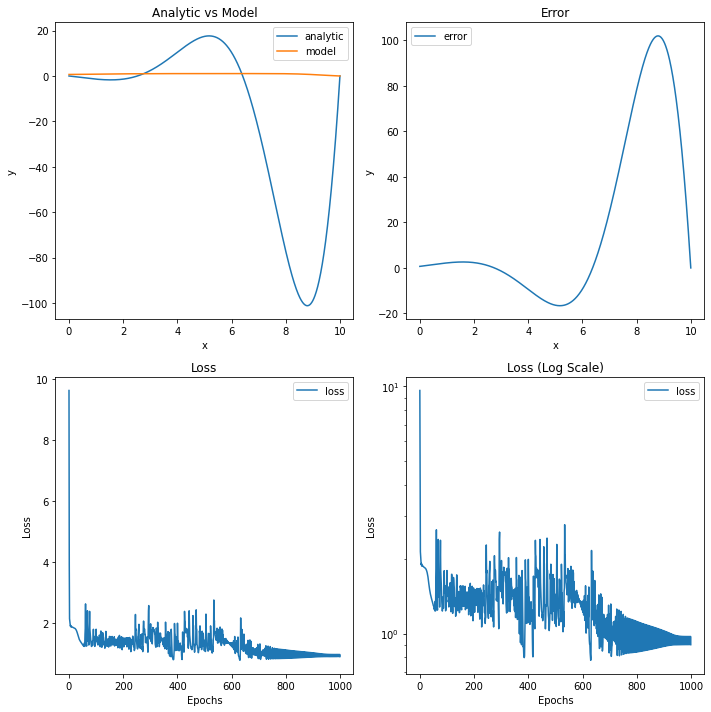

In [8]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx - grad1_fx + fx - 1

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return 0.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 0]
bc_xs = [0.0, 10.0]

x_min = 0.0
x_max = 10.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 100
batch_shuffle = False

x = np.arange(x_min, x_max+discretization, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [200,200]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 1000
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    c1 = -1
    c2 = -1/(np.exp(5)*np.sin(5*np.sqrt(3))) + np.cos(5*np.sqrt(3))/np.sin(5*np.sqrt(3))
    cos_term = c1*np.cos(np.sqrt(3)*x/2)
    sin_term = c2*np.sin(np.sqrt(3)*x/2)
    return 1 + np.exp(x/2)*(cos_term + sin_term)

model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 3
Solve $f''(x)+f'(x)+f(x)-x^2+1=0$ in the domain $x \in [0,5]$ with boundary conditions $f(0) = 0$ and $f(5) = -1$. Analytic solution is 
$$
f(x) = x^2-2 x+e^{-x/2} \cos \left(\frac{\sqrt{3} x}{2}\right)-e^{-x/2} \left(15 e^{5/2}+\cos
   \left(\frac{5 \sqrt{3}}{2}\right)\right) \csc \left(\frac{5 \sqrt{3}}{2}\right) \sin
   \left(\frac{\sqrt{3} x}{2}\right)-1
$$

Epoch 1/2000 Loss: 119.0420
Epoch 2/2000 Loss: 110.9662
Epoch 3/2000 Loss: 104.8289
Epoch 4/2000 Loss: 100.5045
Epoch 5/2000 Loss: 97.7446
Epoch 6/2000 Loss: 96.2432
Epoch 7/2000 Loss: 95.6541
Epoch 8/2000 Loss: 95.6054
Epoch 9/2000 Loss: 95.7472
Epoch 10/2000 Loss: 95.8066
Epoch 11/2000 Loss: 95.6194
Epoch 12/2000 Loss: 95.1323
Epoch 13/2000 Loss: 94.3806
Epoch 14/2000 Loss: 93.4548
Epoch 15/2000 Loss: 92.4686
Epoch 16/2000 Loss: 91.5315
Epoch 17/2000 Loss: 90.7311
Epoch 18/2000 Loss: 90.1212
Epoch 19/2000 Loss: 89.7177
Epoch 20/2000 Loss: 89.5005
Epoch 21/2000 Loss: 89.4212
Epoch 22/2000 Loss: 89.4167
Epoch 23/2000 Loss: 89.4236
Epoch 24/2000 Loss: 89.3923
Epoch 25/2000 Loss: 89.2960
Epoch 26/2000 Loss: 89.1324
Epoch 27/2000 Loss: 88.9201
Epoch 28/2000 Loss: 88.6907
Epoch 29/2000 Loss: 88.4788
Epoch 30/2000 Loss: 88.3134
Epoch 31/2000 Loss: 88.2106
Epoch 32/2000 Loss: 88.1714
Epoch 33/2000 Loss: 88.1827
Epoch 34/2000 Loss: 88.2219
Epoch 35/2000 Loss: 88.2643
Epoch 36/2000 Loss: 88.28

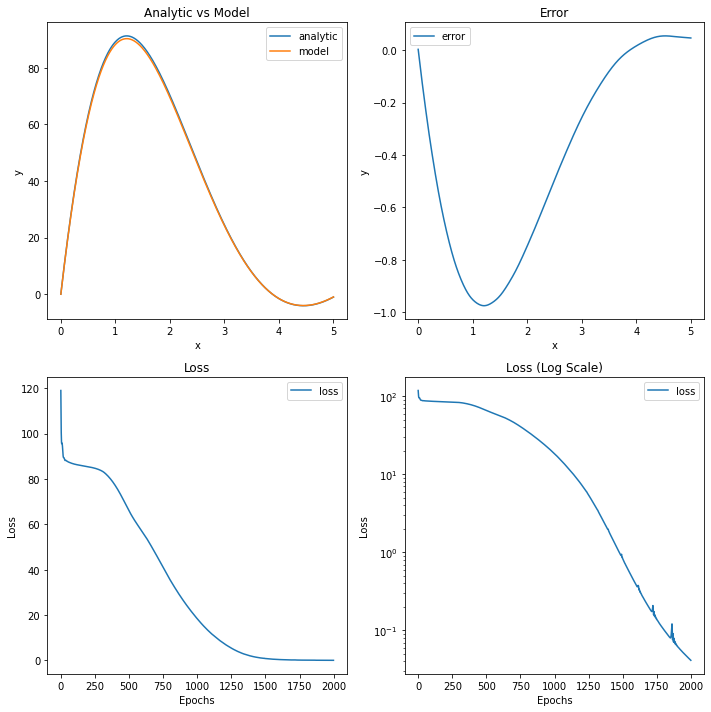

In [9]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx + grad1_fx + fx - x**2 + 1

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return -1.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 0]
bc_xs = [0.0, 5.0]

x_min = 0.0
x_max = 5.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
# discretization = 0.05
num_discretization = 500
batch_size = 500
batch_shuffle = False

# x = np.arange(x_min, x_max, discretization)  # NB x_max is not included in arange
x = np.linspace(x_min, x_max, num_discretization)  # x_max is included in linspace
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 2000
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    cos_term = np.exp(-x/2)*np.cos(np.sqrt(3)*x/2)
    sin_term = -np.exp(-x/2)*(15*np.exp(5/2)+np.cos(5*np.sqrt(3)/2))*np.sin(np.sqrt(3)*x/2)/np.sin(5*np.sqrt(3)/2)
    return -1 - 2*x + x**2 + cos_term + sin_term


model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 4: domain extension
Consider equation $f''(x)-\frac{4 f'(x)}{5}+5 f(x)+x-2=0$ with $x \in [0,\infty[$ and boundary conditions $f(0)=0$ and $f'(0)=0$. This has the analytic solution
$$
f(x) = \frac{1}{1375}\left(506-275 x+217 e^{2 x/5} \sin \left(\frac{11 x}{5}\right)-506
   e^{2 x/5} \cos \left(\frac{11 x}{5}\right)\right)
$$
Compare the solutions with and without domain extension.

Domain 1/4, Epoch 1/4000 Loss: 0.2843
Domain 1/4, Epoch 2/4000 Loss: 5.8380
Domain 1/4, Epoch 3/4000 Loss: 0.5417
Domain 1/4, Epoch 4/4000 Loss: 1.5774
Domain 1/4, Epoch 5/4000 Loss: 3.4375
Domain 1/4, Epoch 6/4000 Loss: 2.3190
Domain 1/4, Epoch 7/4000 Loss: 0.5969
Domain 1/4, Epoch 8/4000 Loss: 0.2818
Domain 1/4, Epoch 9/4000 Loss: 1.2152
Domain 1/4, Epoch 10/4000 Loss: 1.8277
Domain 1/4, Epoch 11/4000 Loss: 1.4017
Domain 1/4, Epoch 12/4000 Loss: 0.5599
Domain 1/4, Epoch 13/4000 Loss: 0.1702
Domain 1/4, Epoch 14/4000 Loss: 0.4673
Domain 1/4, Epoch 15/4000 Loss: 0.9436
Domain 1/4, Epoch 16/4000 Loss: 1.0145
Domain 1/4, Epoch 17/4000 Loss: 0.6446
Domain 1/4, Epoch 18/4000 Loss: 0.2447
Domain 1/4, Epoch 19/4000 Loss: 0.1770
Domain 1/4, Epoch 20/4000 Loss: 0.4148
Domain 1/4, Epoch 21/4000 Loss: 0.6295
Domain 1/4, Epoch 22/4000 Loss: 0.5783
Domain 1/4, Epoch 23/4000 Loss: 0.3367
Domain 1/4, Epoch 24/4000 Loss: 0.1599
Domain 1/4, Epoch 25/4000 Loss: 0.1960
Domain 1/4, Epoch 26/4000 Loss: 0.

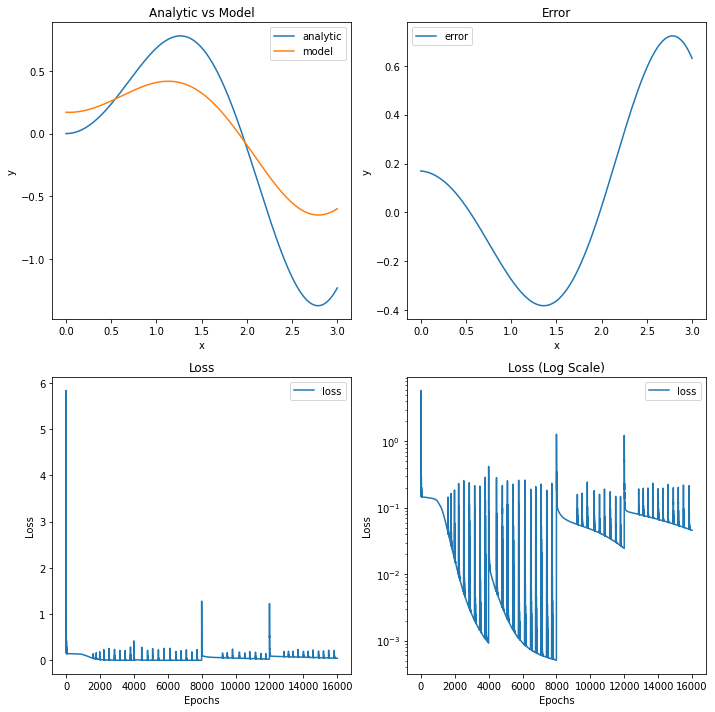

In [18]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx - 0.8*grad1_fx + 5*fx + x - 2

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return 0.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 1]
bc_xs = [0.0, 0.0]

x_min = 0.0
x_max = 3.0


# Using domain extension:

# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
# domains = [[[0.0,2.0]], [[0.0,4.0]], [[0.0,6.0]], [[0.0,8.0]], [[0.0, 10.0]]]
domains = [[[0.0,1.5]], [[0.0,2.0]], [[0.0, 2.5]], [[0.0, 3.0]]]

# Model
hidden_shapes = [100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs_per_domain = 4000
learning_rate = 0.01


# --- Running solver ---
# loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)
loss_data = traininigDomainExtension(model, loss_fn, domains, discretization, num_epochs_per_domain, learning_rate)

# --- Result visualization
def equation_analytic(x):
    cos_term = 506*np.exp(2*x/5)*np.cos(11*x/5)
    sin_term = 217*np.exp(2*x/5)*np.sin(11*x/5)
    return (506 - 275*x + sin_term - cos_term) / 1375

model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

x_eval_tensor.requires_grad_(True)

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()